# Azure Pipeline:

Problem Statement: 

The objective is to analyze the relationship between advertising expenditures across different media sources, including TV, Radio, and Newspaper, and their impact on sales performance. The goal is to determine the optimal allocation of advertising budgets across these channels to maximize sales revenue. By examining the correlation between advertising expenditures and sales, the company aims to identify the most effective advertising strategies and make data-driven decisions to improve its marketing efforts. The insights gained from this analysis will enable the company to optimize resource allocation and develop a robust advertising strategy that aligns with its sales objectives.

Furthermore, the business seeks to create a pipeline for automation purposes. This automation pipeline will save time and resources. The business aims to leverage automation to increase efficiency, accuracy, and agility in optimizing resource allocation and developing a robust advertising strategy that aligns with its sales objectives.

# Setup

**General Imports**

In [1]:
import logging # Importing the logging module for logging purposes
import json # Importing the json module for working with JSON data

**Azure ML imports**

In [2]:
import azureml.core
print(azureml.core.VERSION)

1.56.0


In [3]:
from azure.ai.ml import MLClient # Importing the MLClient class from the azure.ai.ml module
from azure.identity import DefaultAzureCredential # Importing the DefaultAzureCredential class from the azure.identity module
from azure.ai.ml import command, Input, Output, dsl  # Importing the command, Input, Output, and dsl classes from the azure.ai.ml module

**Azure authentication**

In [4]:
#add your authentication details
subscription_id="081da09d-37d8-425c-83bc-747cbea0a4fc" #Provide your subscription ID as shown in the above screenshot
resource_group="azureml24" #Provide your Resource Group as shown in the above screenshot
workspace="azureml"

In [6]:
logger = logging.getLogger("azure.core.pipeline.policies.http_logging_policy")
# Get the logger instance for the "azure.core.pipeline.policies.http_logging_policy" logger.
# This logger is used for logging HTTP requests and responses in the Azure SDK pipeline.
logger.setLevel(logging.WARNING)
# Set the logging level for the logger to WARNING.
# This means that only log messages with a severity level of WARNING or higher will be logged.
# Log messages with lower severity levels, such as INFO or DEBUG, will be ignored.

In [7]:
az_credentials = DefaultAzureCredential(
    exclude_interactive_browser_credential=False
)
# Create an instance of DefaultAzureCredential.
# The DefaultAzureCredential class is used for authenticating with Azure services using default Azure Active Directory credentials.

In [8]:
# The code creates an instance of the MLClient class with the provided parameters.

ml_client = MLClient(
    az_credentials, subscription_id, resource_group, workspace
)

**Upload the dataset as Data asset**

In [9]:
# The code retrieves a list of registered data assets using the ml_client object and prints their names.
for registered_data in ml_client.data.list():
    print(registered_data.name)

carmpg
Advertising_sales_data


**Create a compute resource to run the jobs**

In [10]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_D2_V3",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

Creating a new cpu compute target...
AMLCompute with name cpu-cluster is created, the compute size is STANDARD_D2_V3


# Azure Pipelines

## Step 1: Preprocessing

In [11]:
# The code retrieves a specific version of a registered data asset using the ml_client object.
sales_data = ml_client.data.get("Advertising_sales_data", version="1")

**Processing Script**

Note: Created a folder and name it "data_prep" (which can be used as a directory to store the script) 

**The following code writes the contents of the processing script to a file named "tts.py" in the "data_prep" folder.**

In [12]:
%%writefile data_prep/tts.py

import os
import argparse

import logging
import mlflow

import pandas as pd

from sklearn.model_selection import train_test_split


def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.2)
    parser.add_argument("--train_data", type=str, help="path to train data")
    parser.add_argument("--test_data", type=str, help="path to test data")
    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    print("input data:", args.data)

    df = pd.read_csv(args.data)

    train_df, test_df = train_test_split(
        df,
        test_size=args.test_train_ratio,
        random_state=42
    )

    # output paths are mounted as folder, therefore, we are adding a filename to the path
    train_df.to_csv(os.path.join(args.train_data, "data.csv"), index=False)

    test_df.to_csv(os.path.join(args.test_data, "data.csv"), index=False)

    # Stop Logging
    mlflow.end_run()


if __name__ == "__main__":
    main()

Writing data_prep/tts.py


**Define data preparation steps as a command**

In [13]:
# Define a data preparation step using the command() function
step_process = command(
    name="data_prep_adv_sales", # Name of the step
    display_name="Data preparation for training", # Display name of the step
    description="read a .csv input, split the input to train and test", # Description of the step
    inputs={
        "data": Input(type="uri_folder"), # Input named "data" of type "uri_folder"
        "test_train_ratio": Input(type="number"), # Input named "test_train_ratio" of type "number"
    },
    outputs=dict(
        train_data=Output(type="uri_folder", mode="rw_mount"),  # Output named "train_data" of type "uri_folder" with read-write mount mode
        test_data=Output(type="uri_folder", mode="rw_mount"), # Output named "test_data" of type "uri_folder" with read-write mount mode
    ),
    # The source folder of the component
    code='data_prep/', # Source folder of the component
    command="""python tts.py \
            --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} \
            --train_data ${{outputs.train_data}} --test_data ${{outputs.test_data}} \
            """, # Command to be executed
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest", # Environment for executing the command
)

**The code retrieves the component associated with the step_process**

The Output class to capture the output from the processing script. The object captures the output as a registered folder and holds the state as an attribute. This will enable us to automate the handoff between the processing step and the training step.

In [14]:
step_process.component

CommandComponent({'latest_version': None, 'intellectual_property': None, 'auto_increment_version': True, 'source': 'BUILDER', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'data_prep_adv_sales', 'description': 'read a .csv input, split the input to train and test', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': None, 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/cmlops-p3/code/Users/niger.tasnim21/milestone project 3', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x7f5e08d94be0>, 'command': 'python tts.py             --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}}             --train_data ${{outputs.train_data}} --test_data ${{outputs.test_data}}             ', 'code': 'data_prep/', 'environment_variables': None, 'environment': 'AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest', 'distribution': None, 'resources': None, 'queue_settings': None, 'version': 

In [18]:
step_process.component.inputs

{'data': {'type': 'uri_folder'}, 'test_train_ratio': {'type': 'number'}}

In [19]:
step_process.component.outputs

{'train_data': {'type': 'uri_folder', 'mode': 'rw_mount'},
 'test_data': {'type': 'uri_folder', 'mode': 'rw_mount'}}

## Step 2: Training

Note: Created a folder and name it "train" (which can be used as a directory to store the script) 

**Training Script**

In [20]:
%%writefile train/gbr.py

import os
import mlflow
import argparse

import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor

mlflow.start_run() # Start a new MLflow run

os.makedirs("./outputs", exist_ok=True) # Create the "outputs" directory if it doesn't exist


def select_first_file(path):
    """Selects first file in folder, use under assumption there is only one file in folder
    Args:
        path (str): path to directory or file to choose
    Returns:
        str: full path of selected file
    """
    files = os.listdir(path)
    return os.path.join(path, files[0])


def main():

    parser = argparse.ArgumentParser()
    parser.add_argument("--train_data", type=str, help="path to train data")
    parser.add_argument("--test_data", type=str, help="path to test data")
    parser.add_argument("--n_estimators", required=False, default=100, type=int)
    parser.add_argument("--learning_rate", required=False, default=0.1, type=float)
    parser.add_argument("--registered_model_name", type=str, help="model name")
    parser.add_argument("--model", type=str, help="path to model file")
    args = parser.parse_args() # Parse the command-line arguments

    adv_sales_train = pd.read_csv(select_first_file(args.train_data))  # Read the training data
    adv_sales_test = pd.read_csv(select_first_file(args.test_data)) # Read the test data

    target = 'Sales'
    numeric_features = ['TV','Radio', 'Newspaper']

    # Extract the features from the training data
    X_train = adv_sales_train.drop(columns=[target]) 
    y_train = adv_sales_train[target]

    # Extract the features from the test data
    X_test = adv_sales_test.drop(columns=[target])
    y_test = adv_sales_test[target]

    # Create a column transformer for preprocessing the numeric features
    preprocessor = make_column_transformer(
        (StandardScaler(), numeric_features)
    )

    # Create a Gradient Boosting Regressor model
    model_gbr = GradientBoostingRegressor(
        n_estimators=args.n_estimators,
        learning_rate=args.learning_rate
    )

    # Create a pipeline with preprocessing and the model
    model_pipeline = make_pipeline(preprocessor, model_gbr)

    model_pipeline.fit(X_train, y_train)

    rmse = model_pipeline.score(X_test, y_test)

    mlflow.log_metric("RMSE", float(rmse))

    print("Registering model pipeline")

    mlflow.sklearn.log_model(
        sk_model=model_pipeline,
        registered_model_name="gbr-adv-sales-predictor",
        artifact_path="gbr-adv-sales-predictor"
    ) # Register the model pipeline in MLflow

    mlflow.end_run()


if __name__ == '__main__':
    main()

Writing train/gbr.py


**Define model training steps as a command**

Python command to be executed, which runs the "gbr.py" script with various command-line arguments.

In [21]:
step_train = command(
    name="train_adv_sales_model",
    display_name="Training a advertising data model",
    description="read a .csv input, split the input to train and test",
    inputs={
        "train_data": Input(type="uri_folder"),# Input: Path to the training data (URI folder)
        "test_data": Input(type="uri_folder"), # Input: Path to the test data (URI folder)
        "learning_rate": Input(type="number"), # Input: Learning rate for the model (number)
        "registered_model_name": Input(type="string") # Input: Name for the registered model (string)
    },
    outputs=dict(
        model=Output(type="uri_folder", mode="rw_mount") # Output: Path to the trained model (URI folder)
    ),
    # The source folder of the component
    code='train/',
    command="""python gbr.py \
              --train_data ${{inputs.train_data}} \
              --test_data ${{inputs.test_data}} \
              --learning_rate ${{inputs.learning_rate}} \
              --registered_model_name ${{inputs.registered_model_name}} \
              --model ${{outputs.model}}
            """,
    environment="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu@latest",  # Execution environment for the command
)

** step_train represents a step or command in a pipeline. **

** The output configuration is set to be a folder where the model object will be stored.**

In [22]:
step_train.component

CommandComponent({'latest_version': None, 'intellectual_property': None, 'auto_increment_version': True, 'source': 'BUILDER', 'is_anonymous': False, 'auto_delete_setting': None, 'name': 'train_adv_sales_model', 'description': 'read a .csv input, split the input to train and test', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': None, 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/cmlops-p3/code/Users/niger.tasnim21/milestone project 3', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x7f5de74aa200>, 'command': 'python gbr.py               --train_data ${{inputs.train_data}}               --test_data ${{inputs.test_data}}               --learning_rate ${{inputs.learning_rate}}               --registered_model_name ${{inputs.registered_model_name}}               --model ${{outputs.model}}\n            ', 'code': 'train/', 'environment_variables': None, 'environment': 'AzureML-sklearn-1.0-ubuntu20

In [23]:
step_train.component.inputs

{'train_data': {'type': 'uri_folder'},
 'test_data': {'type': 'uri_folder'},
 'learning_rate': {'type': 'number'},
 'registered_model_name': {'type': 'string'}}

In [24]:
step_train.component.outputs

{'model': {'type': 'uri_folder', 'mode': 'rw_mount'}}

## Step 3: Assemble Pipeline

**So far we have two components that are executable on their own but are not connected to each other. Here is where the `pipeline` function comes into play.**

**Define the pipeline structure**

In [25]:
@dsl.pipeline(
    compute='cpu-cluster',
    description="data preparation and training pipeline"
)
def adv_sales_pipeline(
    pipeline_job_data_input,
    pipeline_job_test_train_ratio,
    pipeline_job_learning_rate,
    pipeline_job_registered_model_name,
):
    # using data_prep_function like a python call with its own inputs
    data_prep_job = step_process(
        data=pipeline_job_data_input,
        test_train_ratio=pipeline_job_test_train_ratio,
    )

    # using train_func like a python call with its own inputs
    train_job = step_train(
        train_data=data_prep_job.outputs.train_data,  # note: using outputs from previous step
        test_data=data_prep_job.outputs.test_data,  # note: using outputs from previous step
        learning_rate=pipeline_job_learning_rate,  # note: using a pipeline input as parameter
        registered_model_name=pipeline_job_registered_model_name,
    )

    # a pipeline returns a dictionary of outputs
    # keys will code for the pipeline output identifier
    return {
        "pipeline_job_train_data": data_prep_job.outputs.train_data,
        "pipeline_job_test_data": data_prep_job.outputs.test_data,
    }

**Create and Run the Pipeline job**

In [26]:
registered_model_name = "adv_sales_model_v1"

In [27]:
pipeline = adv_sales_pipeline(
    pipeline_job_data_input=Input(type="uri_file", path=sales_data.path), # Input path
    pipeline_job_test_train_ratio=0.25, # Input: Test-train ratio for data splitting
    pipeline_job_learning_rate=0.05, # Input: Learning rate for the model
    pipeline_job_registered_model_name=registered_model_name,  # Input: Name for the registered model
)

In [28]:
pipeline_job = ml_client.jobs.create_or_update(
    pipeline,
    # Project's name
    experiment_name="Training pipeline with registered components"
)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Uploading data_prep (0.0 MBs): 100%|██

**Creating a pipeline job in Azure ML creates a UI where the progress of the job can be tracked. Logs could also be streamed from the pipeline.**

**----------------------------------------------------------------------------------------------------------------------------------**

**Following code allows to stream the output of a specific job using its name**

In [29]:
ml_client.jobs.stream(pipeline_job.name)

RunId: tender_van_347jrpxdkx
Web View: https://ml.azure.com/runs/tender_van_347jrpxdkx?wsid=/subscriptions/081da09d-37d8-425c-83bc-747cbea0a4fc/resourcegroups/azureml24/workspaces/azureml

Streaming logs/azureml/executionlogs.txt

[2024-08-17 19:34:21Z] Submitting 1 runs, first five are: c1f56d8d:5bea5b71-7d77-4d34-b42f-a9c83d6a5f66
[2024-08-17 19:41:43Z] Completing processing run id 5bea5b71-7d77-4d34-b42f-a9c83d6a5f66.
[2024-08-17 19:41:44Z] Submitting 1 runs, first five are: 8daaa3ce:a16549aa-4841-4758-88a3-683d882d942b
[2024-08-17 19:42:45Z] Completing processing run id a16549aa-4841-4758-88a3-683d882d942b.

Execution Summary
RunId: tender_van_347jrpxdkx
Web View: https://ml.azure.com/runs/tender_van_347jrpxdkx?wsid=/subscriptions/081da09d-37d8-425c-83bc-747cbea0a4fc/resourcegroups/azureml24/workspaces/azureml



**A screenshot of the pipeline**

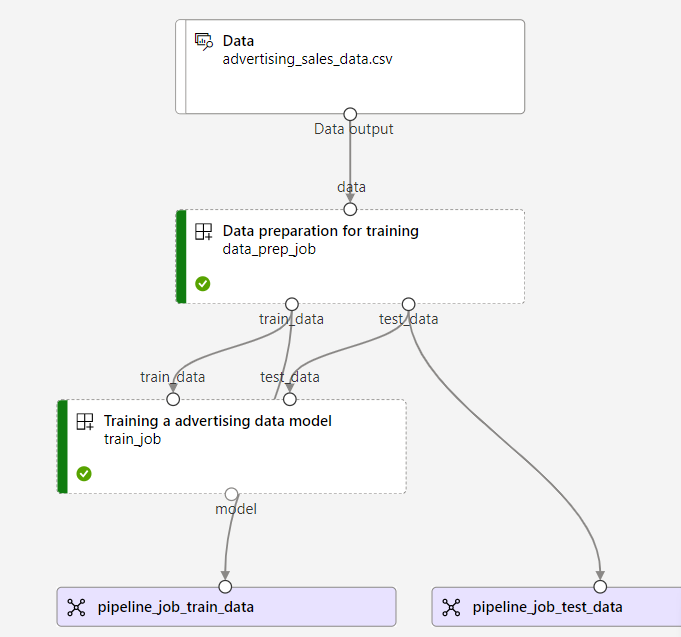

In [30]:
from IPython import display
display.Image("Image/pipeline.png")